## Nutrient Demands



### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [1]:
!pip install -r requirements.txt

In [14]:
import pandas as pd
import cfe.regression as rgsn
import warnings
warnings.filterwarnings('ignore')

### Data



We&rsquo;ll get data from two places.  First, basic data, including a food
 conversion table and recommended daily intakes table can be found in
 a google spreadsheet.

Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [15]:
InputFiles = {'Expenditures':('1POplhyd44h-Zt8jMhXa2FGAzS051TPoLa2xMlmvVLU0','Expenditures'),
              'Prices':('1XaJJuVpHAJ2kK-wOg7CfdENc6XISYY_NKL0lK9wGEcU','Food Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('18EuF3OLGDB6-hb9PToJzDMfyvN8cDqEpzPmQl9leJBU','For Use in Code'),
              'RDI':('1y95IsQ4HKspPW3HHDtH7QMtlDA66IUsCHJLutVL-MMc','diet_minimums'),}

#### Prices, FCT, RDI



In [16]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    return get_clean_df(df)

def get_clean_df(df):
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]
    
    return df
    

# Get prices
#p = get_clean_sheet(InputFiles['Prices'][0],sheet=InputFiles['Prices'][1])

p = read_sheets(InputFiles['Prices'][0],sheet=InputFiles['Prices'][1])
p = p.rename({'': 'units'},axis=1) #Rename units column
p = p.loc[p['units']!='piece'] #Only use kg units..
p = pd.DataFrame(np.vstack([p.columns, p])) # Make t column header as a row
p = p.drop(1, axis=1) # Drop units column
p = p.T #Transpose p
p.columns = p.iloc[0] #Make first row into column header
p = p.drop(0, axis=0) #Drop first row (current column header)
p = p.reset_index(drop=True)

p = get_clean_df(p)

p = p.drop('j',axis=1)

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.rename(columns={"Item name": "j"})

fct = fct.set_index('j')
fct.columns.name = 'n'
fct = fct.drop('Value',axis=1)

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
fct = fct.dropna(how='all',axis=0)

################## RDI, if available (consider using US) ##################### ## CHECK: Are we using US or Tanzania?
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])

rdi = rdi.rename(columns={"Nutrition": "n"})
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [17]:
r = rgsn.read_pickle('Tanzania_results.pickle')  # Assumes you've already set this up e.g., in Project 3

In [18]:
r

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [6]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.xs('2010-11',level='t').mean()

pbar = pbar[r.beta.index] # Only use prices for goods we can estimate

#### Budgets



Get food budget for all households, then find median budget:



In [7]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [8]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

j                                 Beef     Bread  Cassava fresh   Chicken   
i     t       m                                                             
1     2012-13 Mainland Rural  0.555117  0.818410       3.563872  0.706799  \
      2014-15 Mainland Rural  1.003237  1.151854       3.704444  1.444235   
2     2014-15 Mainland Rural  0.808600  0.947611       2.895680  1.245344   
4     2012-13 Mainland Rural  0.177281  0.288673       1.367066  0.217727   
      2014-15 Mainland Rural  0.760627  0.955789       2.593857  1.227097   
...                                ...       ...            ...       ...   
14974 2014-15 Mainland Rural  0.743405  0.946368       3.035711  1.189340   
14979 2014-15 Mainland Rural  2.152228  2.622942       5.623407  2.910675   
14980 2014-15 Mainland Rural  1.145856  1.463922       3.248821  1.635055   
14981 2014-15 Mainland Rural  1.470890  2.242089       5.277094  2.455794   
14983 2014-15 Mainland Rural  1.213343  1.381356       3.960147  1.785542   

j                             Citrus fruits  Coconuts  Cooking oil     Dairy   
i     t       m                                                                
1     2012-13 Mainland Rural       0.554148  1.188973     0.372619  0.482494  \
      2014-15 Mainland Rural       1.000775  1.879495     0.583514  1.361778   
2     2014-15 Mainland Rural       0.976377  1.625441     0.546331  1.235574   
4     2012-13 Mainland Rural       0.145835  0.555890     0.134649  0.196704   
      2014-15 Mainland Rural       0.774950  1.640022     0.485135  1.295193   
...                                     ...       ...          ...       ...   
14974 2014-15 Mainland Rural       0.737634  1.496276     0.477704  0.814780   
14979 2014-15 Mainland Rural       2.553872  3.366004     1.503995  2.525840   
14980 2014-15 Mainland Rural       1.292693  2.088786     0.824930  1.239259   
14981 2014-15 Mainland Rural       2.451553  2.838477     1.033834  1.461780   
14983 2014-15 Mainland Rural       1.345643  2.091805     0.732603  1.968615   

j                             Dried/salted/canned fish      Eggs  ...   
i     t       m                                                   ...   
1     2012-13 Mainland Rural                  0.381735  0.172022  ...  \
      2014-15 Mainland Rural                  0.612837  0.326735  ...   
2     2014-15 Mainland Rural                  0.610202  0.336331  ...   
4     2012-13 Mainland Rural                  0.143495  0.058577  ...   
      2014-15 Mainland Rural                  0.538644  0.273027  ...   
...                                                ...       ...  ...   
14974 2014-15 Mainland Rural                  0.539644  0.234601  ...   
14979 2014-15 Mainland Rural                  1.687337  0.573860  ...   
14980 2014-15 Mainland Rural                  0.866240  0.381491  ...   
14981 2014-15 Mainland Rural                  1.213389  0.732603  ...   
14983 2014-15 Mainland Rural                  0.877300  0.390555  ...   

j                             Plantains  Rice (husked)  Ripe bananas   
i     t       m                                                        
1     2012-13 Mainland Rural   1.922827       2.411936      0.464584  \
      2014-15 Mainland Rural   2.453232       3.082451      0.929370   
2     2014-15 Mainland Rural   2.286531       2.741245      0.797484   
4     2012-13 Mainland Rural   0.782086       1.122933      0.119199   
      2014-15 Mainland Rural   2.312928       2.966149      0.753881   
...                                 ...            ...           ...   
14974 2014-15 Mainland Rural   2.065338       2.835221      0.707010   
14979 2014-15 Mainland Rural   5.709123       7.944908      2.584627   
14980 2014-15 Mainland Rural   3.197843       4.776794      1.126506   
14981 2014-15 Mainland Rural   4.432154       6.958037      2.269413   
14983 2014-15 Mainland Rural   3.219885       3.945036      1.072731   

j                                 Salt  Soft drinks   
i     t       m

Finally, define a function to change a single price in the vector $p$:



In [9]:
def my_prices(p0,p=pbar,j='Beef'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



<IPython.core.display.Javascript object>


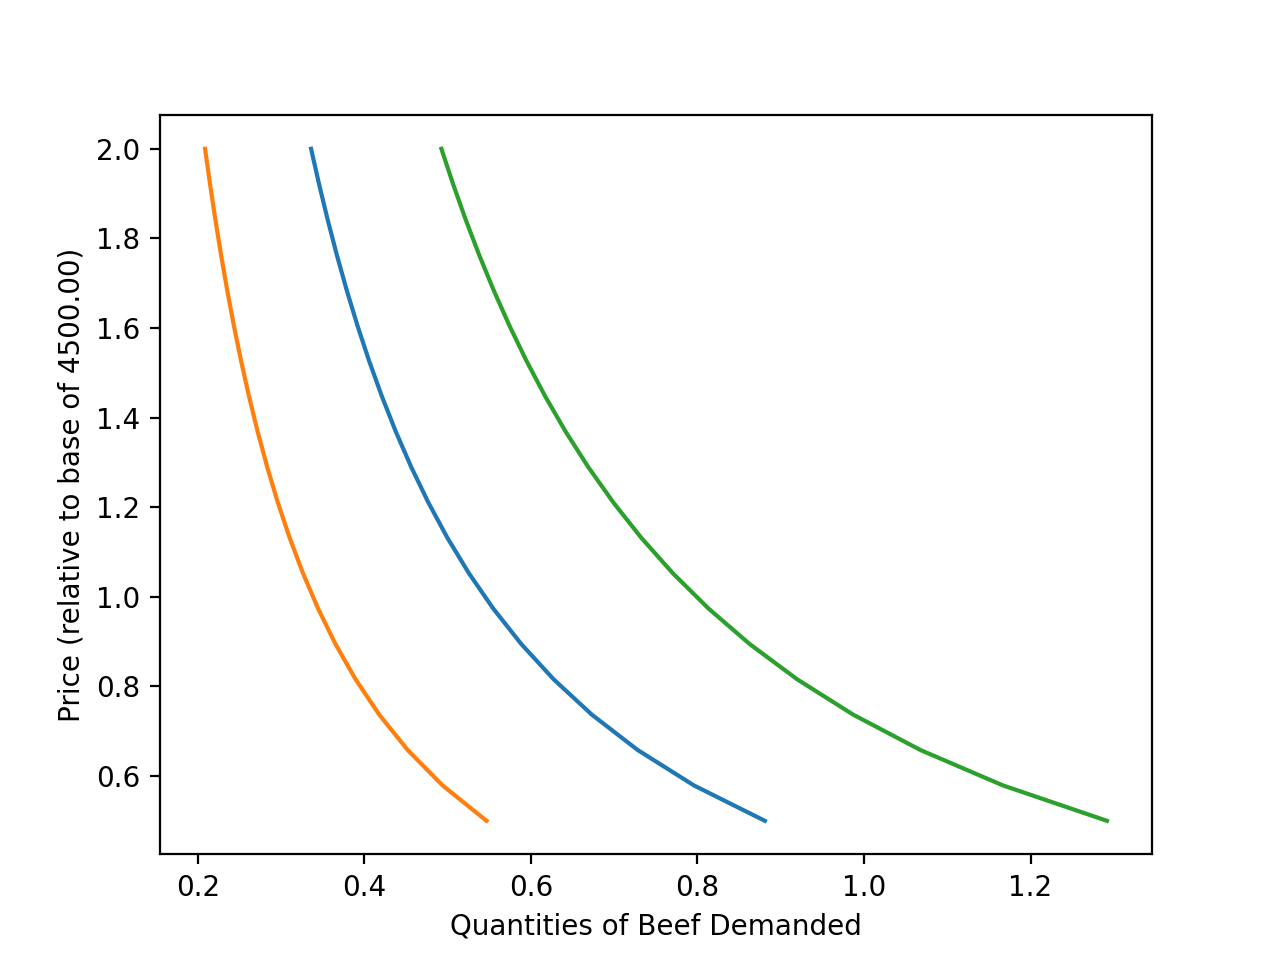

Text(0.5, 0, 'Quantities of Beef Demanded')

In [10]:
import matplotlib.pyplot as plt
%matplotlib notebook

use = 'Beef'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([r.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



<IPython.core.display.Javascript object>


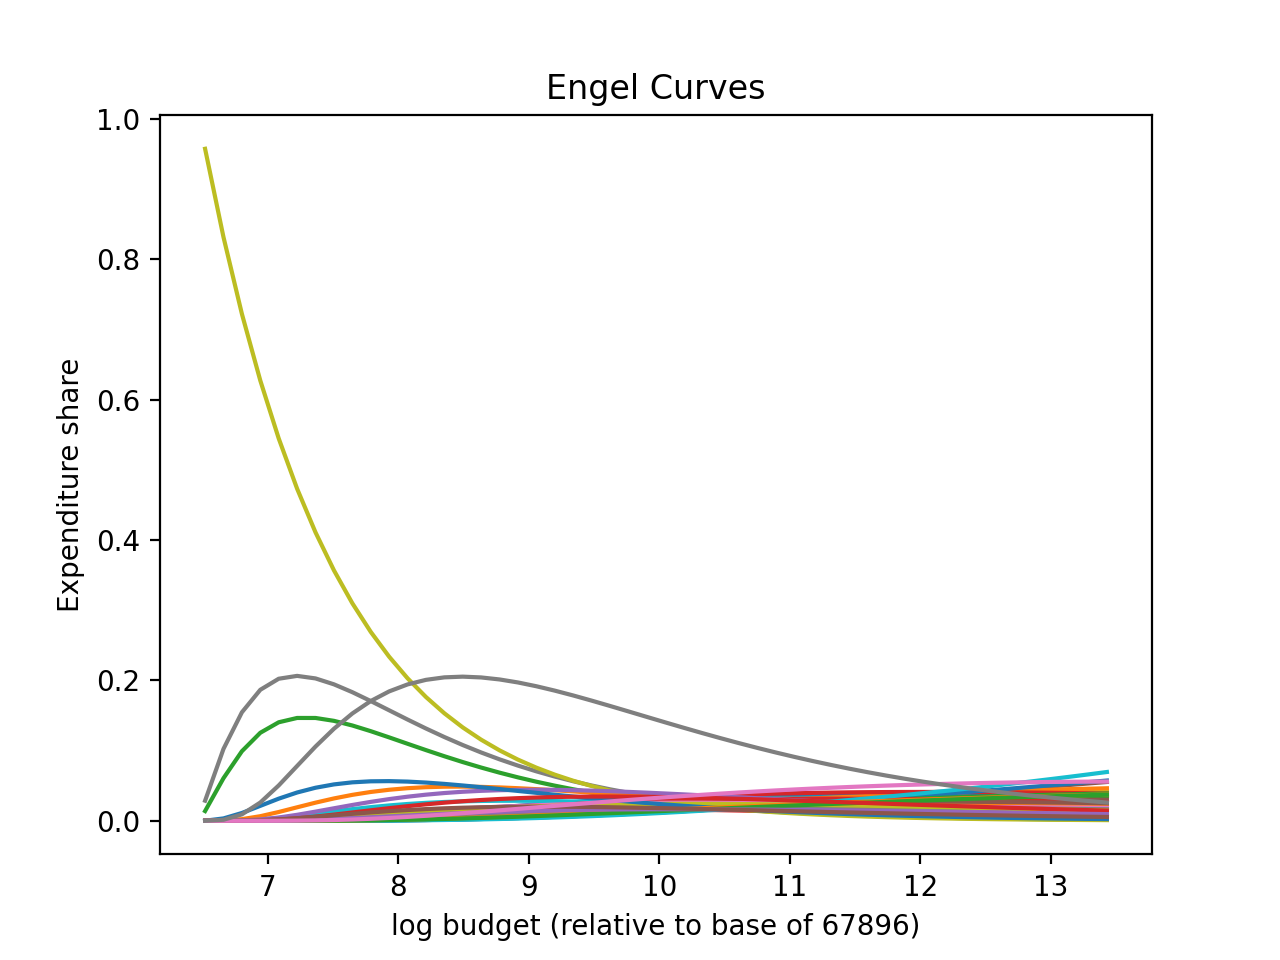

Text(0.5, 1.0, 'Engel Curves')

In [11]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [12]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Sugar', 'Eggs', 'Fresh milk', 'Salt'], dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [13]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i                    1                             2              4       
t                  2012-13        2014-15        2014-15        2012-13   
m           Mainland Rural Mainland Rural Mainland Rural Mainland Rural   
n                                                                         
energy kcal     368.730231     556.280967     460.484783     160.929455  \
protein g         6.877592      12.170144      12.537455       2.494282   
vit a ug        170.617332     316.252348     325.627456      59.431447   
vit d ug          1.376179       2.613876       2.690651       0.468617   
vit e ug          0.455756       0.837745       0.862659       0.159954   
vit c mg          0.000000       0.000000       0.000000       0.000000   
vit b6 mg         0.068809       0.130694       0.134533       0.023431   
vit b12 ug        1.840227       3.383655       3.484271       0.645675   
ca mg           157.246589     257.915354     264.023055      63.483154   
mg mg            18.393869      31.217767      32.103563       7.029335   
fe mg             1.106331       2.049911       2.077694       0.394861   
zn mg             0.361247       0.686143       0.706296       0.123012   

i                                   5                             8       
t                  2014-15        2012-13        2014-15        2012-13   
m           Mainland Rural Mainland Rural Mainland Rural Mainland Rural   
n                                                                         
energy kcal     472.924923     995.969917    1162.295146     494.124787  \
protein g        10.437424      19.077866      23.012476      10.312944   
vit a ug        266.610477     348.634926     464.280643     219.014809   
vit d ug          2.184212       2.264219       3.276280       1.604692   
vit e ug          0.708407       0.992422       1.292489       0.603101   
vit c mg          0.000000       0.000000       0.000000       0.000000   
vit b6 mg         0.109211       0.113211       0.163814       0.080235   
vit b12 ug        2.860929       3.997990       5.210909       2.432461   
ca mg           227.483014     538.306145     606.995608     265.886549   
mg mg            27.194083      59.371822      68.403658      30.050733   
fe mg             1.718923       1.883238       2.661048       1.295634   
zn mg             0.573356       0.594358       0.860024       0.421232   

i                                   9      ...                14966   
t                  2014-15        2012-13  ...              2014-15   
m           Mainland Rural Mainland Rural  ... Mainland Other Urban   
n                                          ...                        
energy kcal     639.017520     237.523911  ...           623.575349  \
protein g        13.204712       3.491738  ...            16.454023   
vit a ug        318.798424      88.015440  ...           335.021528   
vit d ug          2.532800       0.716046  ...             2.380671   
vit e ug          0.855887       0.234425  ...             0.930806   
vit c mg          0.000000       0.000000  ...             0.000000   
vit b6 mg         0.126640       0.035802  ...             0.119034   
vit b12 ug        3.455209       0.946650  ...             3.752981   
ca mg           304.418640      83.294866  ...           428.685305   
mg mg            35.703234       9.444015  ...            48.602906   
fe mg             2.013251       0.597802  ...             1.872920   
zn mg             0.664860       0.187962  ...             0.624926   

i                          14968          14970          14971          14972   
t                        2014-15        2014-15        2014-15        2014-15   
m           Mainland Other Urban Mainland Rural Mainland Rural Mainland Rural   
n                                                                               
energy kcal          1176.571792     523.529154     572.210545     568.288930  \
protein g              25.367669      10.331902      11.

Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [14]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    #print(c)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    #print(fct0)
    #print(c0)
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



<IPython.core.display.Javascript object>


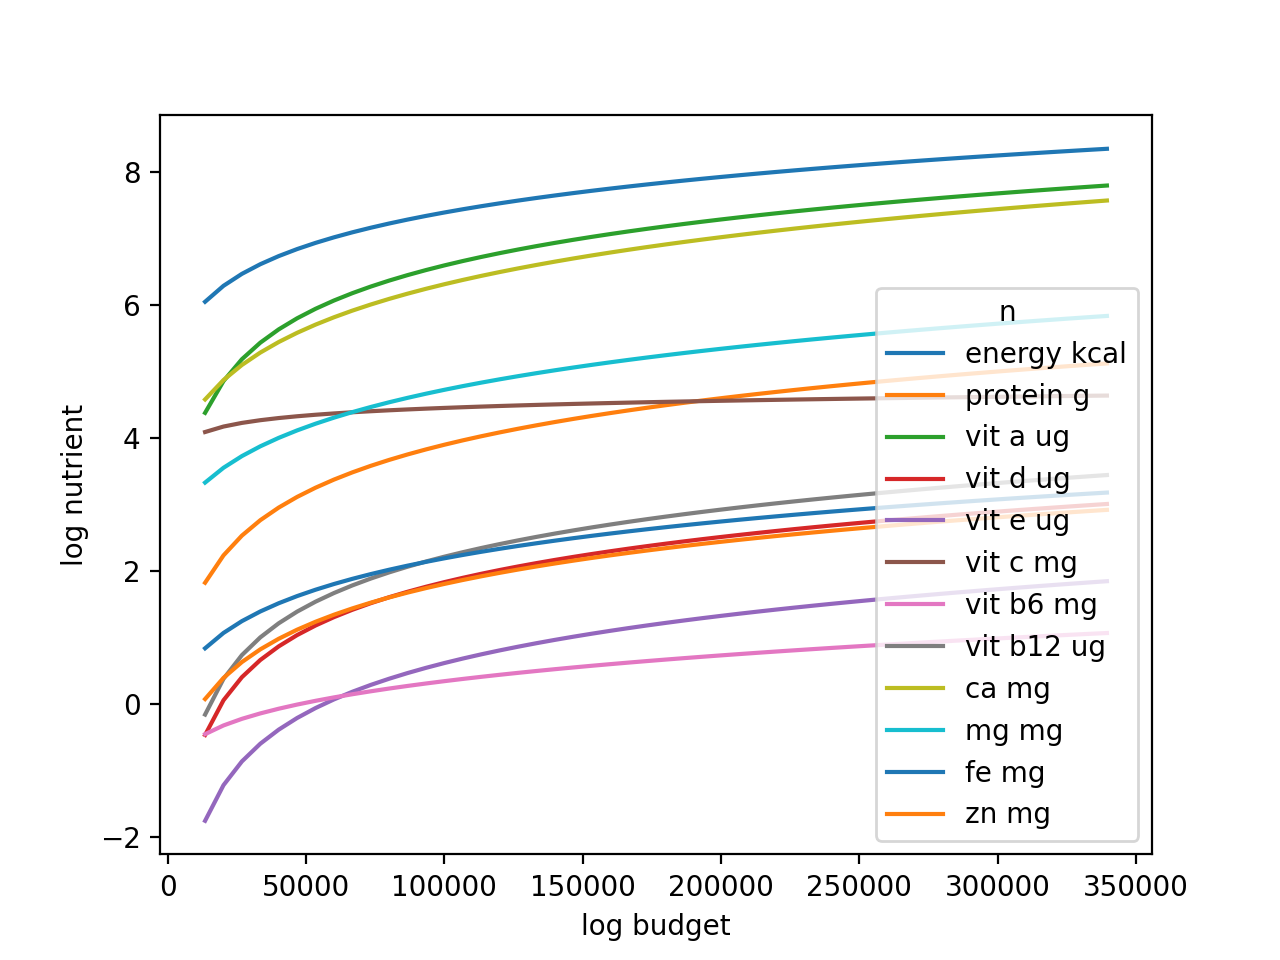

Text(0, 0.5, 'log nutrient')

In [15]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = list(N.index)

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
#df = pd.DataFrame({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X}).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



<IPython.core.display.Javascript object>


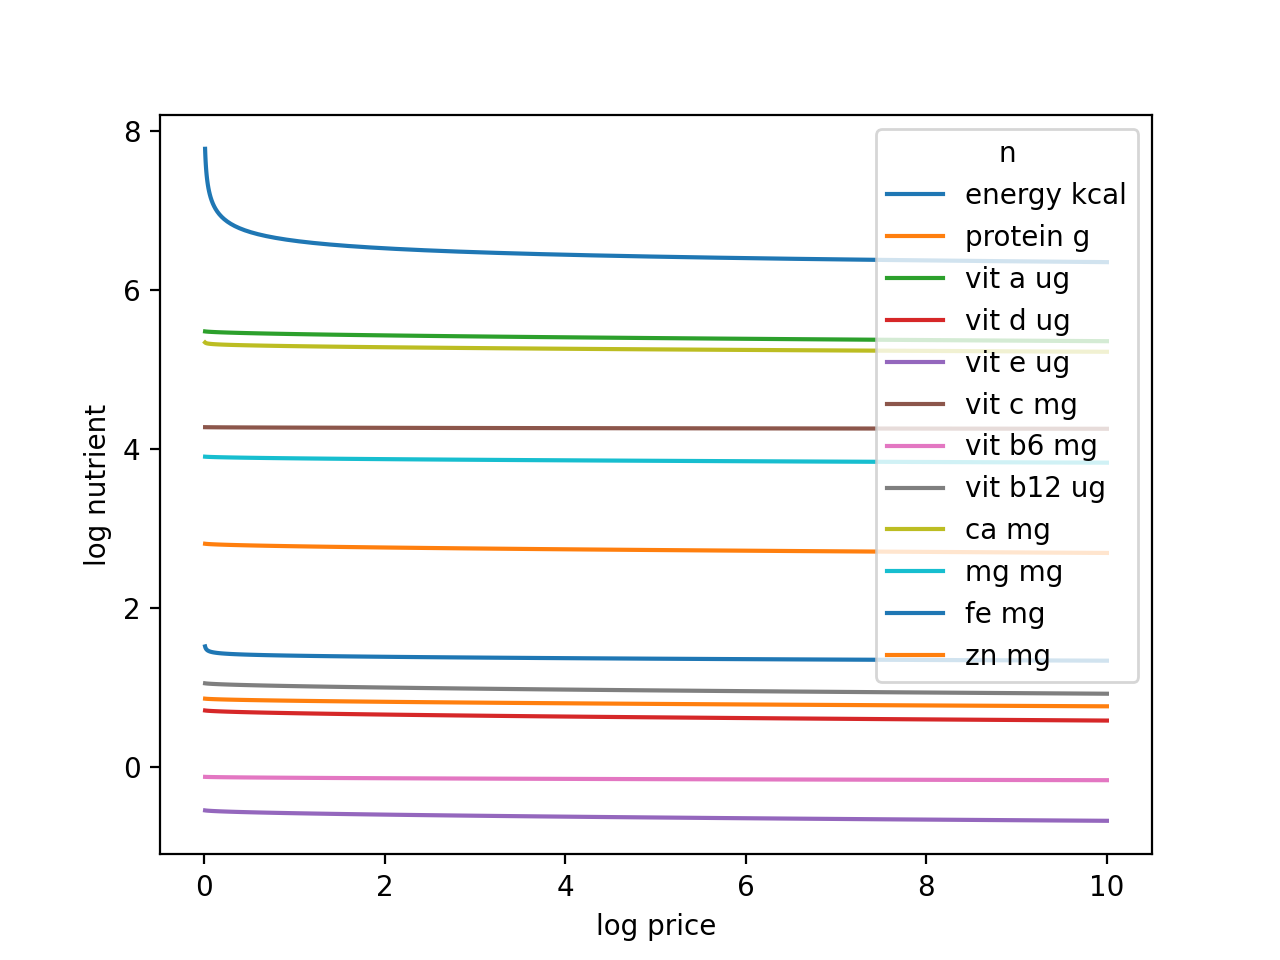

Text(0, 0.5, 'log nutrient')

In [16]:
USE_GOOD = 'Sugar'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [17]:
# In first round, averaged over households and villages
dbar = r.d.mean().iloc[:-2]

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [18]:
rdi = rdi.drop("Source",axis=1)
rdi["Males 00-03"] = rdi["C 1-3"]
rdi_map = {'C 1-3': 'Females 00-03', 'F 4-8': 'Females 04-08', 'F 9-13': 'Females 09-13', 'F 14-18': 'Females 14-18', 
 'F 19-30': 'Females 19-30', 'F 31-50': 'Females 31-50', 'F 51+': 'Females 51-99', 
 'M 4-8' : 'Males 04-08', 'M 9-13' : 'Males 09-13', 'M 14-18': 'Males 14-18', 'M 19-30': 'Males 19-30', 
 'M 31-50': 'Males 31-50', 'M 51+' : 'Males 51-99'}

In [19]:
rdi = rdi.rename(columns = rdi_map)
rdi

k,Females 00-03,Females 04-08,Males 04-08,Females 09-13,Males 09-13,Females 14-18,Males 14-18,Females 19-30,Males 19-30,Females 31-50,Males 31-50,Females 51-99,Males 51-99,Males 00-03
n,,,,,,,,,,,,,,
Energy,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0,1000.0
Protein,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0,13.0
"Fiber, total dietary",14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0,14.0
"Folate, DFE",150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,150.0
"Calcium, Ca",700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0,700.0
"Carbohydrate, by difference",130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
"Iron, Fe",7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0,7.0
"Magnesium, Mg",80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0,80.0
Niacin,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0,6.0


In [20]:
dbar = dbar.drop("log HSize")

In [21]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi.replace('',0)@dbar

hh_rdi

n
Energy                            11927.128651
Protein                             264.405221
Fiber, total dietary                166.979801
Folate, DFE                        2223.912368
Calcium, Ca                        7264.356743
Carbohydrate, by difference         891.215040
Iron, Fe                             73.718148
Magnesium, Mg                      1898.244251
Niacin                               84.790553
Phosphorus, P                      5475.711622
Potassium, K                      29667.402113
Riboflavin                            6.644981
Thiamin                               6.457007
Vitamin A, RAE                     4427.501554
Vitamin B-12                         13.343474
Vitamin B-6                           7.351973
Vitamin C, total ascorbic acid      397.799099
Vitamin E (alpha-tocopherol)         82.927284
Vitamin K (phylloquinone)           527.801429
Zinc, Zn                             53.677284
dtype: float64

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [22]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



<IPython.core.display.Javascript object>


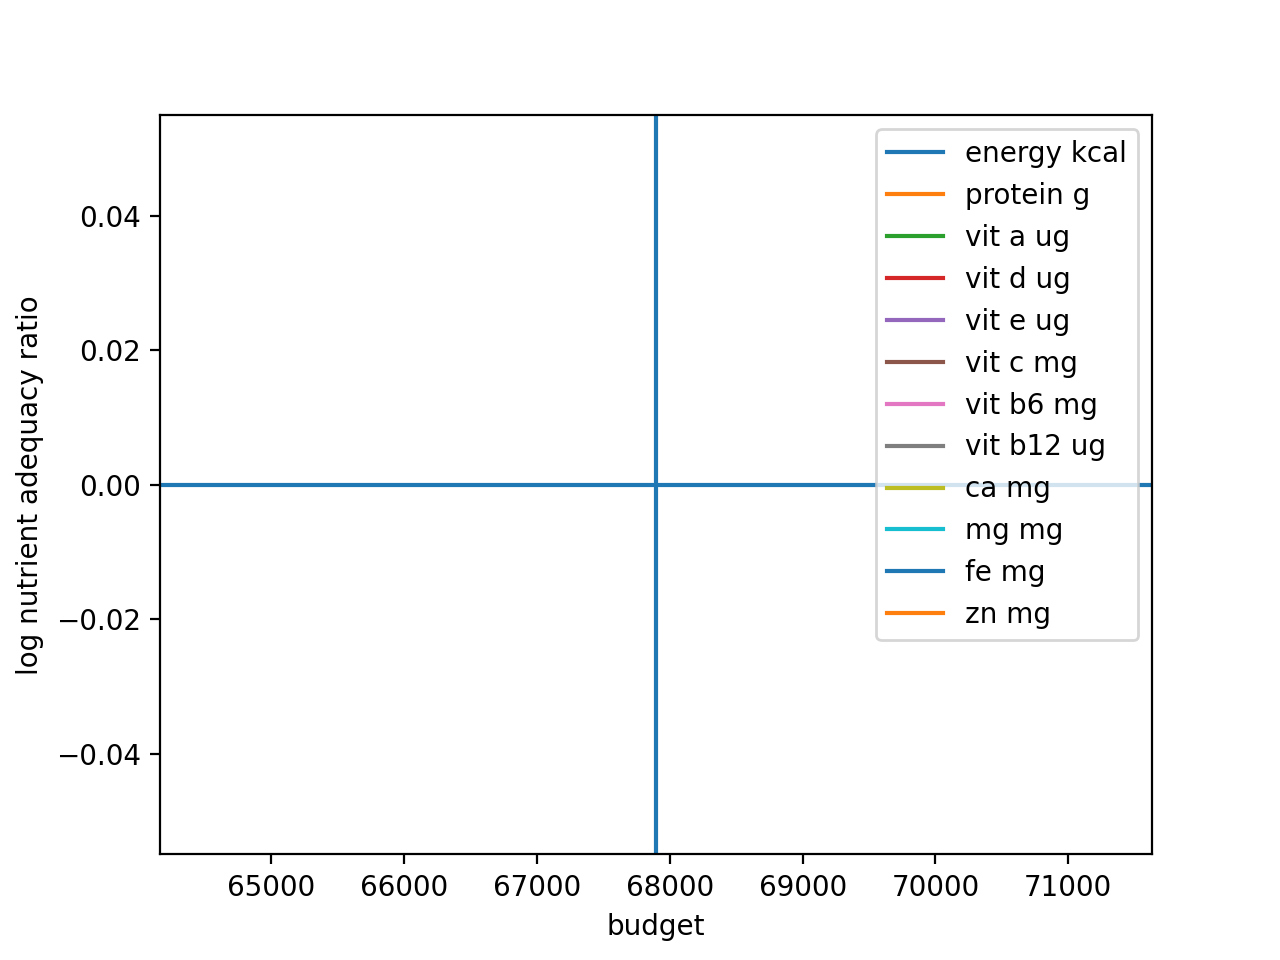

In [23]:
X = np.geomspace(.01*xref,2*xref,100)

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



<IPython.core.display.Javascript object>


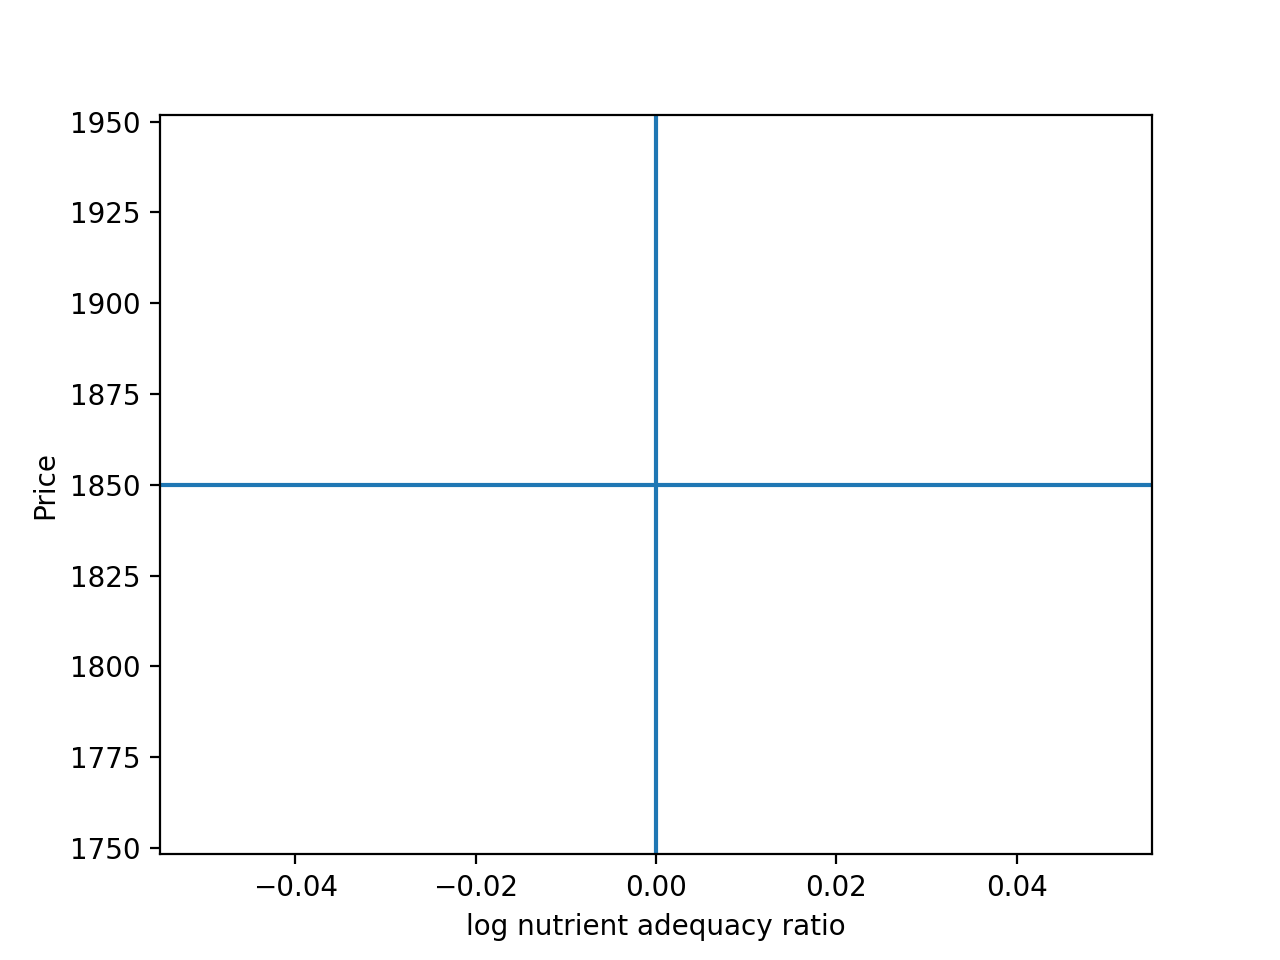

Text(0.5, 0, 'log nutrient adequacy ratio')

In [24]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['zn mg'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')

We Worked through calculating nutritional demands and adequacy above.

We will now work through example calculating costs of price changes

## Policy: Calculating Costs of Price Changes

#### Reference Prices

Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.

In [30]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.xs('2010-11',level='t').mean()
pbar = pbar[r.beta.index] # Only use prices for goods we can estimate

#### Budgets

Get food budget for all households, then find median budget:

In [32]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
x0 = xbar.quantile(0.5)  # Household at 0.5 quantile is median

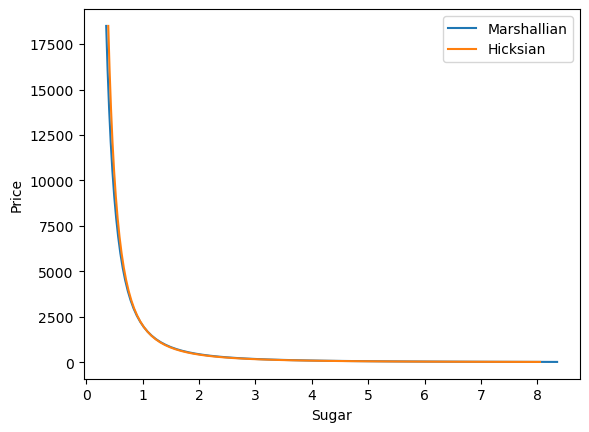

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

my_j = 'Sugar'  # Interesting Ugandan staple

P = np.geomspace(.01,10,50)*pbar[my_j]

# Utility of median household, given prices
U0 = r.indirect_utility(x0,pbar)

plt.plot([r.demands(x0,my_prices(p0,j=my_j))[my_j] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,j=my_j),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))

#### Welfare measures

In [36]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian')

#### Price Changes, Revenue, and Compensating Variation

Examine effects of price changes on revenue (if price change due to a
tax or subsidy) and compensating variation.

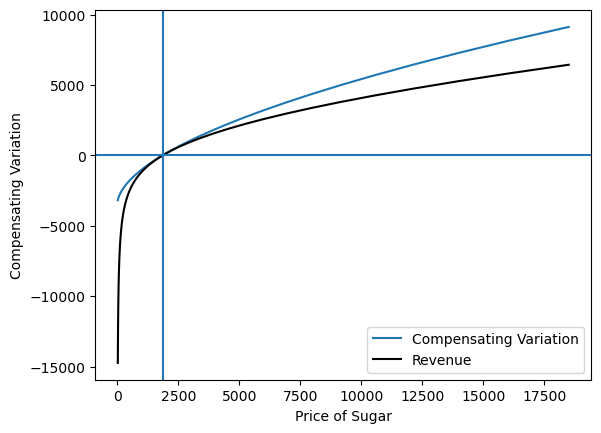

In [38]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(p0,j=my_j),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(pbar.loc[my_j])

#### Deadweight Loss

Differences between revenue and compensating variation is deadweight-loss:

Text(0, 0.5, 'Deadweight Loss')

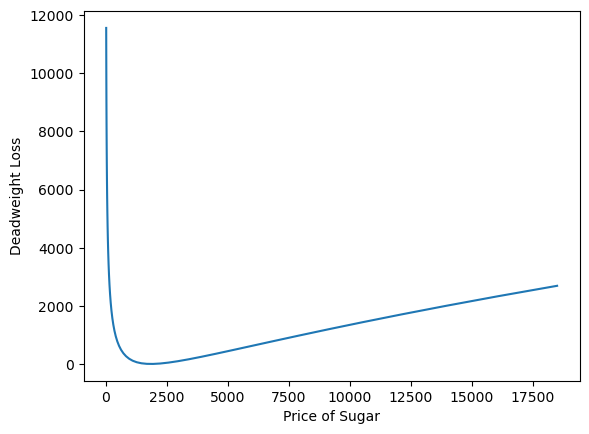

In [40]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j)
ax1.set_ylabel("Deadweight Loss")